# Importing all the necessary Libs

In [ ]:
import tensorflow as tf
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, RNN, LSTMCell
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm



warnings.filterwarnings('ignore')

# Data-Preprocessing

In [2]:
def load_and_preprocess_mnist():
    """
    Loads the MNIST dataset and preprocesses it by normalizing the image pixel values.
    
    Returns:
        Tuple of numpy arrays: (train_images, train_labels), (test_images, test_labels)
        where image data is normalized to have values between 0 and 1.
    """
    # Load the MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    
    # Normalize the image data to 0-1 range
    train_images, test_images = train_images / 255.0, test_images / 255.0
    
    return (train_images, train_labels), (test_images, test_labels)

# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = load_and_preprocess_mnist()
    
# Print the shapes of the datasets to verify
print("Training Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)

Training Images Shape: (60000, 28, 28)
Test Images Shape: (10000, 28, 28)


In [3]:
def fragment_image(image, fragment_size=(7, 7)):
    """
    Fragments a single image into smaller parts.
    
    Parameters:
    - image: The image to be fragmented.
    - fragment_size: A tuple indicating the size of the fragments.
    
    Returns:
    - A list of image fragments.
    """
    fragments = []
    for start_row in range(0, image.shape[0], fragment_size[0]):
        for start_col in range(0, image.shape[1], fragment_size[1]):
            end_row = start_row + fragment_size[0]
            end_col = start_col + fragment_size[1]
            fragments.append(image[start_row:end_row, start_col:end_col])
    return fragments

def transform_mnist_data(data):
    """
    Transforms MNIST data by fragmenting each image into smaller parts.
    
    Parameters:
    - data: The MNIST images dataset.
    
    Returns:
    - A numpy array of fragmented images.
    """
    fragmented_images = [fragment_image(image) for image in data]
    return np.array(fragmented_images)

def get_model_ready_data(data):
    """
    Prepares model input and output data from the fragmented images.
    
    Parameters:
    - data: Fragmented images dataset.
    
    Returns:
    - Tuple of numpy arrays: (input data, output data)
    """
    xdata = data[:, :-1, :]
    ydata = data[:, 1:, :]
    return xdata, ydata


# Transforming MNIST data
train_images_frag = transform_mnist_data(train_images).reshape(60000, 16, 49)
test_images_frag = transform_mnist_data(test_images).reshape(10000, 16, 49)

# Getting model-ready data
x_train, y_train = get_model_ready_data(train_images_frag)
x_test, y_test = get_model_ready_data(test_images_frag)

# Output shapes
print(x_train.shape)  # (60000, 15, 49)
print(y_train.shape)  # (60000, 15, 49)
print(x_test.shape)   # (10000, 15, 49)
print(y_test.shape)   # (10000, 15, 49)



(60000, 15, 49)
(60000, 15, 49)
(10000, 15, 49)
(10000, 15, 49)


# Pre-Processed Data visualization 

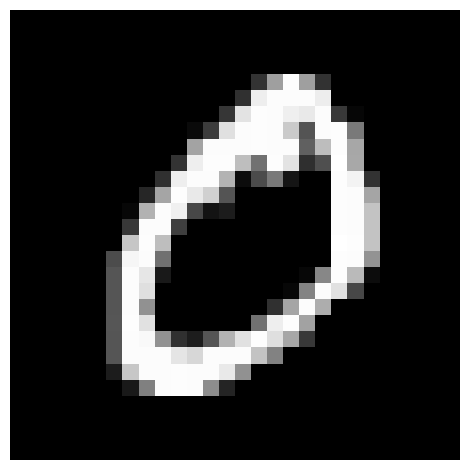

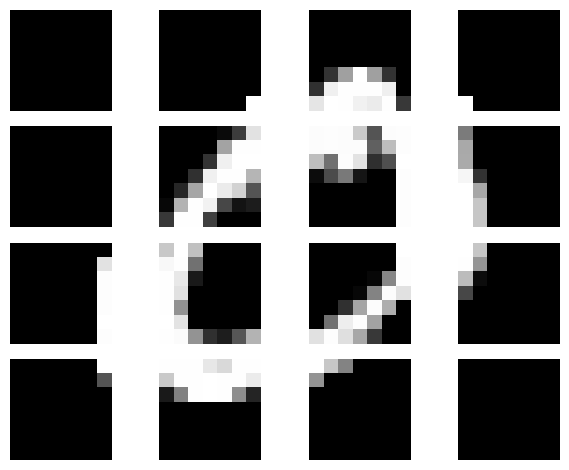

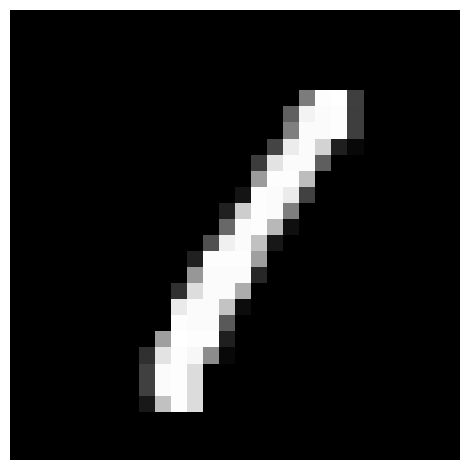

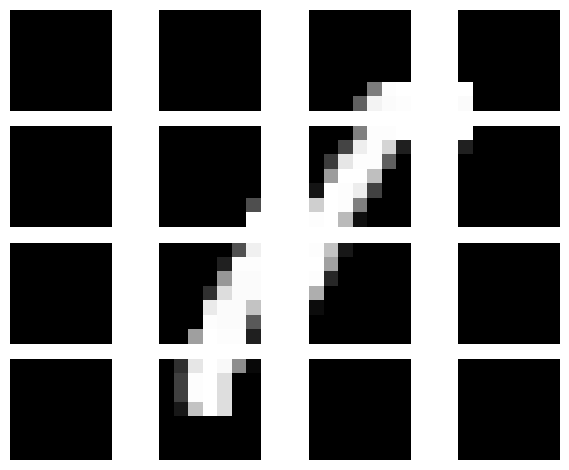

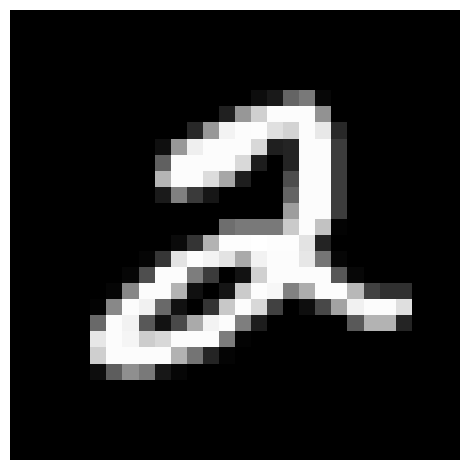

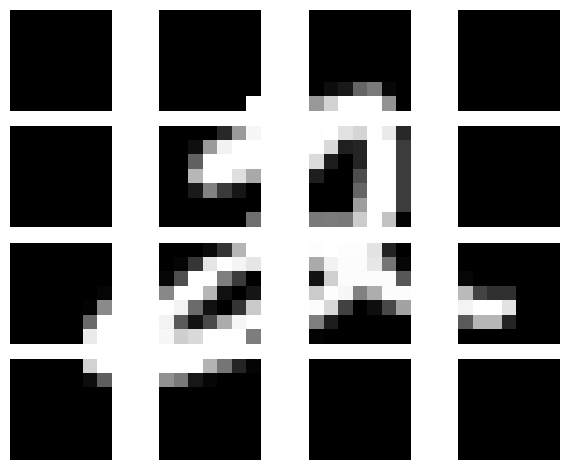

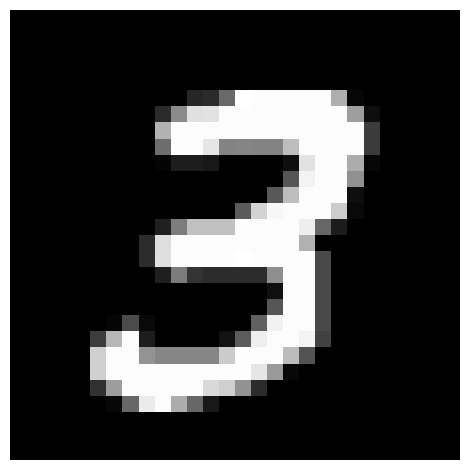

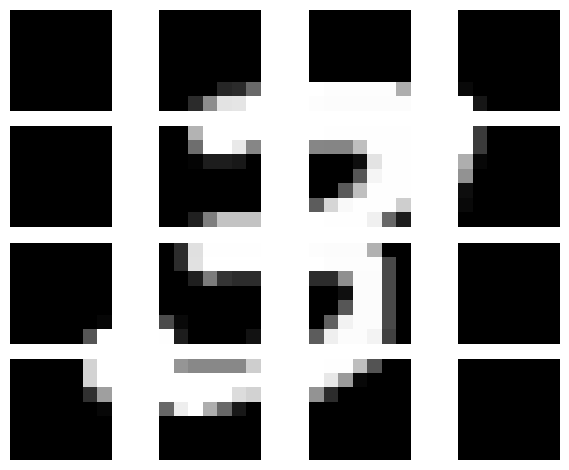

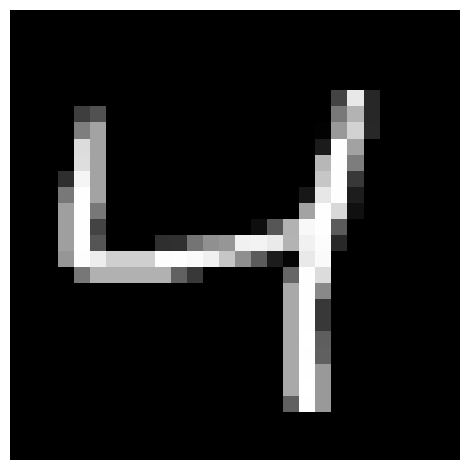

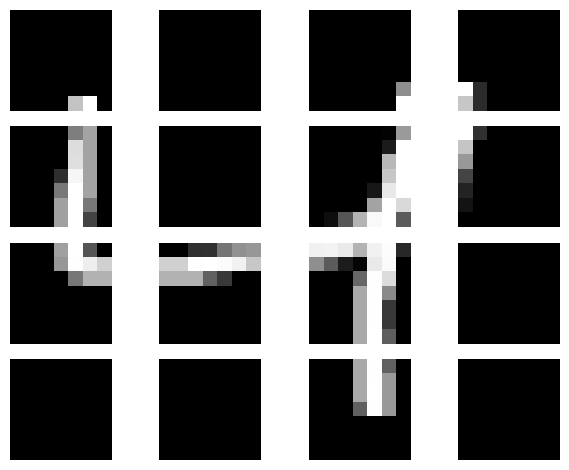

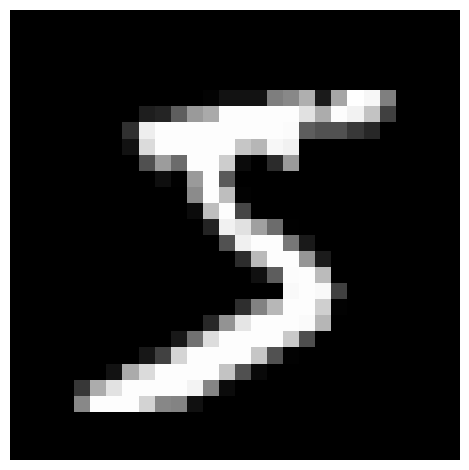

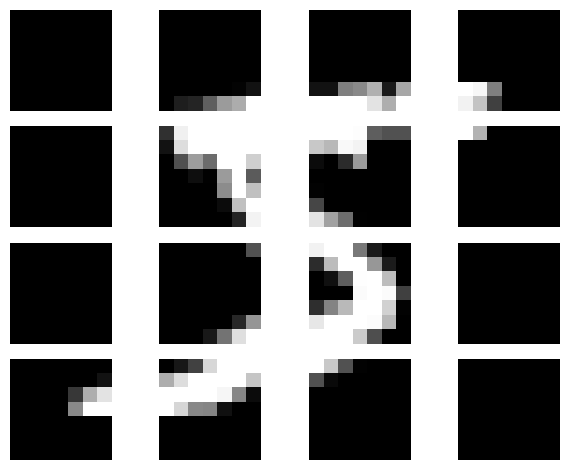

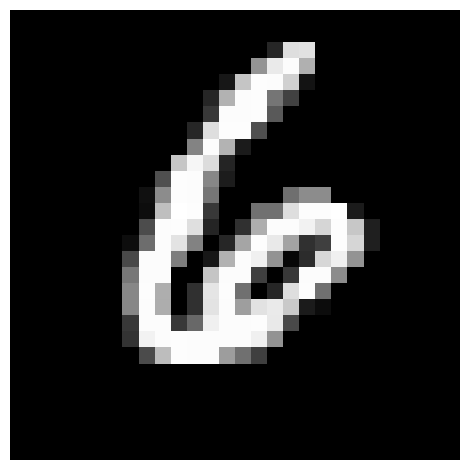

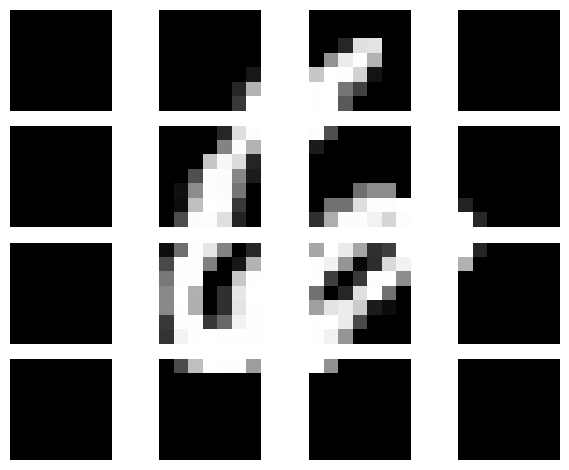

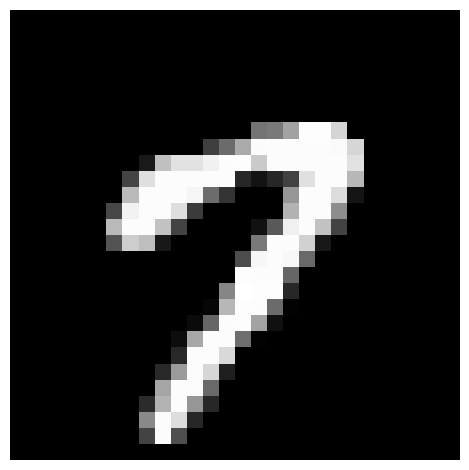

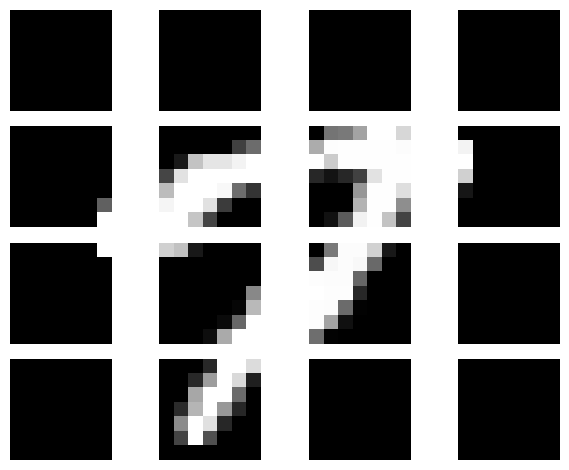

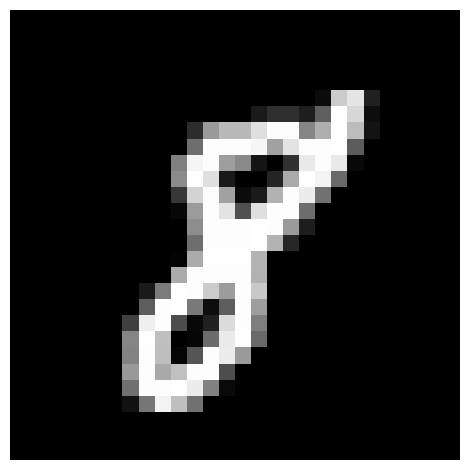

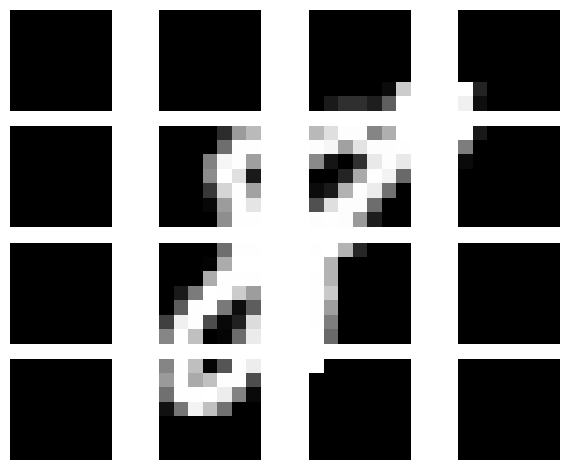

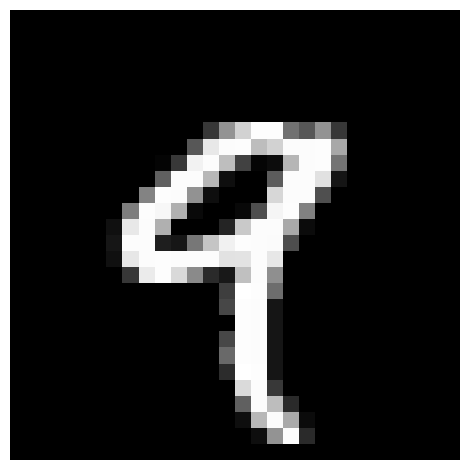

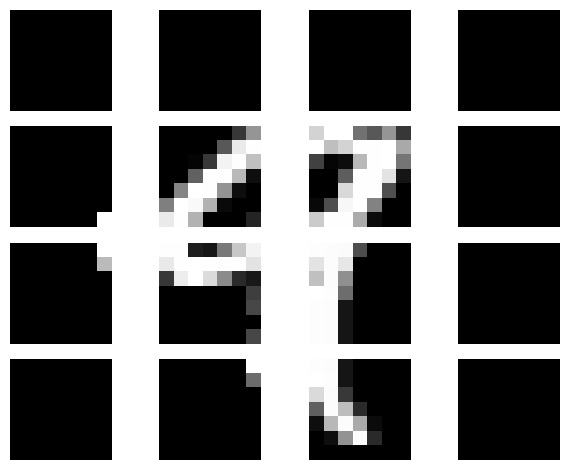

In [4]:
def find_first_label_indices(labels):
    """
    Finds the indices of the first occurrence of each unique label in the dataset.

    Parameters:
    - labels: numpy.ndarray, an array of labels for the dataset.

    Returns:
    - A list of indices representing the first occurrence of each unique label.
    """
    unique_labels = np.unique(labels)
    first_indices = [np.argmax(labels == label) for label in unique_labels]
    return first_indices

def plot_digit(image, fragments):
    """
    Plots an image and its corresponding fragmented parts, with adjustment for reshaping fragments.

    Parameters:
    - image: numpy.ndarray, the original image of the digit.
    - fragments: numpy.ndarray, an array containing the fragmented parts of the image, each of shape (49,).
    """
    # Plot the original image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Plot each fragment in a 4x4 grid, reshaping each from (49,) back to (7, 7)
    for i in range(16):
        plt.subplot(4, 4, i+1)
        fragment_reshaped = fragments[i].reshape(7, 7)  # Reshape fragment to 2D
        plt.imshow(fragment_reshaped, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Commented out to prevent execution in the PCI
label_indices = find_first_label_indices(train_labels)
for index in label_indices:
    plot_digit(train_images[index], train_images_frag[index])



# Initializing Model Parameters

In [6]:
def initialize_rnn_states(train_size, test_size, units_per_layer):
    """
    Initializes the hidden states (hs) and cell states (hc) for both training and testing datasets.

    Parameters:
    - train_size: int, the size of the training dataset.
    - test_size: int, the size of the testing dataset.
    - units_per_layer: int, the number of units (neurons) in each layer of the RNN/LSTM.

    Returns:
    - A dictionary containing numpy arrays for hs_input, hc_input, hs_output, hc_output
      for both training and testing datasets.
    """
    # Initialize arrays for training dataset
    hs_input_train = np.zeros((train_size, units_per_layer))
    hc_input_train = np.zeros((train_size, units_per_layer))
    hs_output_train = np.zeros((train_size, units_per_layer))
    hc_output_train = np.zeros((train_size, units_per_layer))

    # Initialize arrays for testing dataset
    hs_input_test = np.zeros((test_size, units_per_layer))
    hc_input_test = np.zeros((test_size, units_per_layer))
    hs_output_test = np.zeros((test_size, units_per_layer))
    hc_output_test = np.zeros((test_size, units_per_layer))

    # Returning all initialized arrays in a structured dictionary
    return {
        "hs_input_train": hs_input_train, "hc_input_train": hc_input_train,
        "hs_output_train": hs_output_train, "hc_output_train": hc_output_train,
        "hs_input_test": hs_input_test, "hc_input_test": hc_input_test,
        "hs_output_test": hs_output_test, "hc_output_test": hc_output_test
    }



# Defining Model Parameters

In [7]:
# Initialize RNN states for both training and testing datasets
rnn_states = initialize_rnn_states(60000, 10000, 256)
unit_per_layer = 256
# Define the model with additional inputs for the initial states
inputs = Input(shape=(None, 49))
hs_input_l = Input(shape=(unit_per_layer,))
hc_input_l = Input(shape=(unit_per_layer,))
rnn = RNN(LSTMCell(unit_per_layer), return_sequences=True, return_state=True)
whole_seq_output, hs_output_l, hc_output_l = rnn(inputs, initial_state=[hs_input_l, hc_input_l])
outputs = Dense(units=49, activation='relu')(whole_seq_output)
model = Model(inputs=[inputs, hs_input_l, hc_input_l], outputs=[outputs, hs_output_l, hc_output_l])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)





You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
# Initialize RNN states for both training and testing datasets
rnn_states = initialize_rnn_states(60000, 10000, 256)
unit_per_layer = 256
# Define the model with additional inputs for the initial states
inputs = Input(shape=(None, 49))
hs_input_l = Input(shape=(unit_per_layer,))
hc_input_l = Input(shape=(unit_per_layer,))
rnn = RNN(LSTMCell(unit_per_layer), return_sequences=True, return_state=True)
whole_seq_output, hs_output_l, hc_output_l = rnn(inputs, initial_state=[hs_input_l, hc_input_l])
outputs = Dense(units=49, activation='relu')(whole_seq_output)
model = Model(inputs=[inputs, hs_input_l, hc_input_l], outputs=[outputs, hs_output_l, hc_output_l])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Fit the model with initialized states
model.fit(
    [x_train, rnn_states['hs_input_train'], rnn_states['hc_input_train']], 
    [y_train, rnn_states['hs_output_train'], rnn_states['hc_output_train']],
    batch_size=100, epochs=50, 
    validation_data=(
        [x_test, rnn_states['hs_input_test'], rnn_states['hc_input_test']],
        [y_test, rnn_states['hs_output_test'], rnn_states['hc_output_test']]
    )
)

# Save the model
model.save("p1_model.h5")


Epoch 1/50


600/600 [==============================] - 17s 26ms/step - loss: 0.0561 - dense_1_loss: 0.0546 - rnn_1_loss: 3.4304e-04 - rnn_1_1_loss: 0.0011 - dense_1_accuracy: 0.2621 - rnn_1_accuracy: 1.6667e-05 - rnn_1_1_accuracy: 5.0000e-05 - val_loss: 0.0418 - val_dense_1_loss: 0.0410 - val_rnn_1_loss: 2.0025e-04 - val_rnn_1_1_loss: 5.5673e-04 - val_dense_1_accuracy: 0.3354 - val_rnn_1_accuracy: 0.0000e+00 - val_rnn_1_1_accuracy: 0.0000e+00
Epoch 2/50
600/600 [==============================] - 15s 25ms/step - loss: 0.0389 - dense_1_loss: 0.0383 - rnn_1_loss: 1.6687e-04 - rnn_1_1_loss: 4.3938e-04 - dense_1_accuracy: 0.3749 - rnn_1_accuracy: 1.6667e-05 - rnn_1_1_accuracy: 8.3333e-05 - val_loss: 0.0365 - val_dense_1_loss: 0.0361 - val_rnn_1_loss: 1.2076e-04 - val_rnn_1_1_loss: 3.0405e-04 - val_dense_1_accuracy: 0.3920 - val_rnn_1_accuracy: 0.0000e+00 - val_rnn_1_1_accuracy: 0.0000e+00
Epoch 3/50
600/600 [==============================] - 15s 25ms/step - loss: 0.0353 - dense_1_loss: 0.0

# Test dataset Prep

In [35]:
def find_indices_by_label(labels, label, num_samples):
    """
    Finds the indices of the first `num_samples` occurrences of a given `label` in `labels`.

    Parameters:
    - labels: numpy.ndarray, the array of labels.
    - label: int, the target label to find.
    - num_samples: int, the number of indices to find for the given label.

    Returns:
    - numpy.ndarray, indices of the first `num_samples` occurrences of the label.
    """
    return np.where(labels == label)[0][:num_samples]

def extract_images_by_indices(images, indices):
    """
    Extracts images corresponding to the specified indices from the dataset.

    Parameters:
    - images: numpy.ndarray, the dataset of images.
    - indices: numpy.ndarray, the indices of images to extract.

    Returns:
    - List of numpy.ndarray, the extracted images.
    """
    return [images[index] for index in indices]

def collect_sampled_images(test_labels, test_images, test_images_frag, num_classes=10, samples_per_class=10):
    """
    Collects a specified number of images and their fragments for each class from the test dataset.

    Parameters:
    - test_labels: numpy.ndarray, the array of test labels.
    - test_images: numpy.ndarray, the dataset of test images.
    - test_images_frag: numpy.ndarray, the dataset of fragmented test images.
    - num_classes: int, the number of classes (digits) to collect samples for.
    - samples_per_class: int, the number of samples to collect per class.

    Returns:
    - Tuple of numpy.ndarray, the collected images and their fragments.
    """
    full_images, frag_images = [], []

    for i in range(num_classes):
        indices = find_indices_by_label(test_labels, i, samples_per_class)
        full_images.extend(extract_images_by_indices(test_images, indices))
        frag_images.extend(extract_images_by_indices(test_images_frag, indices))

    return np.array(full_images), np.array(frag_images)


test_10_img_data_full_np, test_10_img_data_frag_np = collect_sampled_images(test_labels, test_images, test_images_frag)
print(test_10_img_data_full_np.shape)
print(test_10_img_data_frag_np.shape)


(100, 28, 28)
(100, 16, 49)


# Testing Model Performace

100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


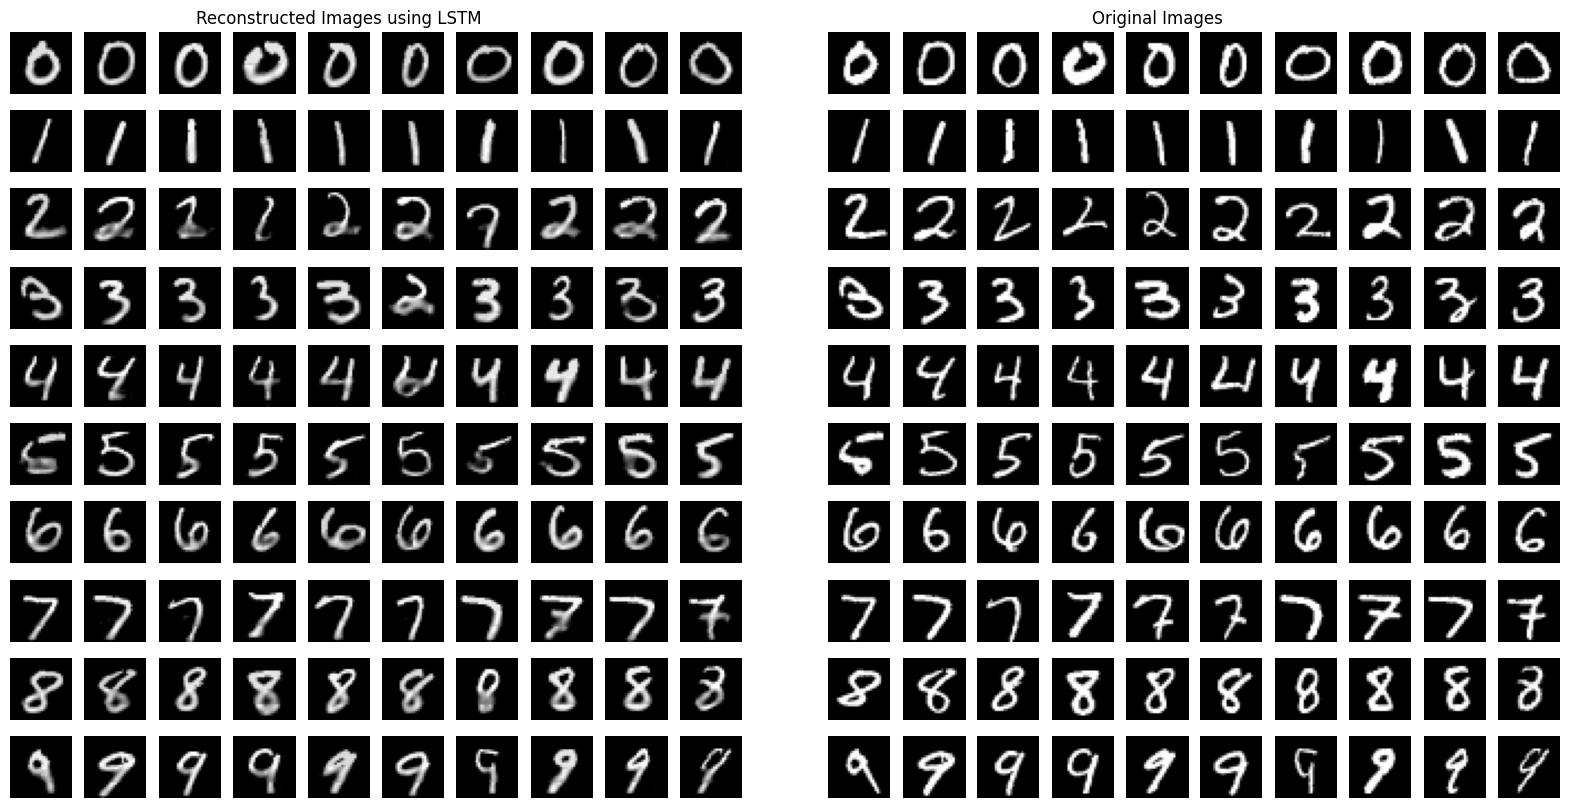

In [51]:
# Constants
UNIT_PER_LAYER = 256
IMAGE_SIZE = 7  # Assuming images are 7x7 for reshaping

def reconstruct_images(model, test_data, num_images=100):
    """
    Reconstruct images using the LSTM model. Ensures all arrays for concatenation
    have consistent dimensions by correctly reshaping model outputs.

    Parameters:
    - model: The LSTM model used for prediction.
    - test_data: The test data for image reconstruction, expected to be in a shape that includes
                 the fragment size at the end (e.g., (1, 1, 49) for each fragment).
    - num_images: Number of images to reconstruct.

    Returns:
    - A list of reconstructed images.
    """
    reconstructed_images = []
    for i in tqdm(range(num_images)):
        hs = np.zeros((1, UNIT_PER_LAYER))
        hc = np.zeros((1, UNIT_PER_LAYER))
        final_output = []

        # Initial sequence prediction with model
        for j in range(8):  # Assuming 8 fragments to predict the next part of the image
            output, hs, hc = model.predict([test_data[i][j].reshape(1, 1, -1), hs, hc], verbose=0)
            # Reshape fragment from test_data for consistency in dimensions
            fragment = test_data[i][j].reshape(IMAGE_SIZE, IMAGE_SIZE)
            final_output.append(fragment)
        # Process the model's last output separately to match dimensions
        final_output.append(output.reshape(IMAGE_SIZE, IMAGE_SIZE))

        # Further prediction based on the last output
        for j in range(7):
            output, hs, hc = model.predict([output, hs, hc], verbose=0)
            # Ensure output is reshaped to (IMAGE_SIZE, IMAGE_SIZE)
            final_output.append(output.reshape(IMAGE_SIZE, IMAGE_SIZE))

        # Reconstruct the image from 2D fragments
        reconstructed_img = np.concatenate([np.concatenate(final_output[i*4:(i+1)*4], axis=1) for i in range(4)], axis=0)
        reconstructed_images.append(reconstructed_img)
    return reconstructed_images

def calculate_subplot_index(i, start_col, num_cols):
    # Calculate the row and column index based on the image index and starting column
    row = i // num_cols
    col = i % num_cols + start_col
    return row, col

def plot_images(axs, images, start_row, start_col, num_cols, title=None):
    """
    Plot a series of images on the given axes, ensuring proper wrapping to the next row.

    Parameters:
    - axs: The matplotlib subplot axes.
    - images: The images to plot.
    - start_row: The starting row on the subplot grid.
    - start_col: The starting column on the subplot grid.
    - num_cols: Number of columns to use before wrapping to the next row.
    - title: The title for the first subplot, if any.
    """
    if title:
        axs[start_row, start_col+4].set_title(title)

    for i, img in enumerate(images):
        row, col = calculate_subplot_index(i, start_col, num_cols)
        axs[row, col].imshow(img, cmap='gray')
        axs[row, col].axis('off')

def simple(test):
    return 1

x = simple(1)

def main(model, test_data_fragmented, test_data_full):
    '''
    Main function to orchestrate the reconstruction and plotting of images.

    Parameters:
    - model: The LSTM model for image prediction.
    - test_data_fragmented: The fragmented test data for reconstruction.
    - test_data_full: The full images for comparison.
    '''
    fig, axs = plt.subplots(10, 21, figsize=(20, 10))
    
    # Reconstruct images
    reconstructed_images = reconstruct_images(model, test_data_fragmented)

    # Plot reconstructed images
    plot_images(axs, reconstructed_images, start_row=0, start_col=0, num_cols=10, title='Reconstructed Images using LSTM')

    # Plot original images
    plot_images(axs, test_data_full, start_row=0, start_col=11, num_cols=10, title='Original Images')

    # Remove the axis of the 10th column (separation column)
    for i in range(10):
        axs[i, 10].axis('off')

    plt.show()

main(model, test_10_img_data_frag_np, test_10_img_data_full_np)
